# Solvation Models
- There are a two solvation models in cryojax related to Parkhurst et al. [1].
- This notebook documents in what sense they are equivalent to each other.

[1] Parkhurst, J. M., Cavalleri, A., Dumoux, M., Basham, M., Clare, D., Siebert, C. A., … Essex, J. W. (2024). 
Computational models of amorphous ice for accurate simulation of cryo-EM images of biological samples. Ultramicroscopy, 256(October 2023), 113882. 
http://doi.org/10.1016/j.ultramic.2023.113882 

## Explicit water
The water coordinates used in Parkhurst et al. are available in ref. [2]

[2] Cavalleri, A., Parkhurst, J. M., Dumoux, M., Basham, M., Evans, G., Naismith, J. H., … Essex, J. (2023, April). Simulated water models with Apoferritin for use in cryo-EM image simulations with amorphous ice. Zenodo. http://doi.org/10.5281/zenodo.7862117

In [2]:
from cryojax.io import read_atoms_from_pdb_or_cif


fname = "../../data/water_243_coords.pdb"
atom_positions, atom_identities, b_factors = read_atoms_from_pdb_or_cif(
    fname, center=True, get_b_factors=True
)

In [3]:
import jax.numpy as jnp
import numpy as np
from jaxtyping import install_import_hook


with install_import_hook("cryojax", "typeguard.typechecked"):
    from cryojax.image import irfftn
    from cryojax.io import read_atoms_from_pdb_or_cif
    from cryojax.simulator import (
        GaussianMixtureProjection,
        InstrumentConfig,
        PengAtomicPotential,
    )

In [4]:
shape = (200, 200)
atom_potential = PengAtomicPotential(atom_positions, atom_identities, b_factors)
pixel_size = 1
potential_integrator = GaussianMixtureProjection(upsampling_factor=4)
instrument_config = InstrumentConfig(
    shape=shape,
    pixel_size=pixel_size,
    voltage_in_kilovolts=300.0,
)
fourier_integrated_potential = potential_integrator.compute_fourier_integrated_potential(
    atom_potential, instrument_config
)

In [5]:
image = irfftn(fourier_integrated_potential)
image.mean()

Array(5.825688, dtype=float32)

In [6]:
import cryojax as cx
from cryojax.image import compute_radially_averaged_powerspectrum, irfftn, rfftn


def compute_power_spectrum(integrated_potential, shape, voxel_size):
    integrated_potential_unbiased = integrated_potential - jnp.mean(integrated_potential)
    freq_grid = cx.coordinates.make_frequency_grid(shape, voxel_size)
    radial_freq_grid = jnp.linalg.norm(freq_grid, axis=-1)
    fourier_image = rfftn(integrated_potential_unbiased)
    n_pixels = fourier_image.shape[0]
    spectrum, frequencies = compute_radially_averaged_powerspectrum(
        fourier_image,
        radial_freq_grid,
        voxel_size,
        maximum_frequency=1 / (2 * voxel_size),
    )
    return frequencies, spectrum / n_pixels


frequencies, spectrum = compute_power_spectrum(image - image.mean(), shape, pixel_size)

Text(0.5, 1.0, 'Normalized image power spectrum')

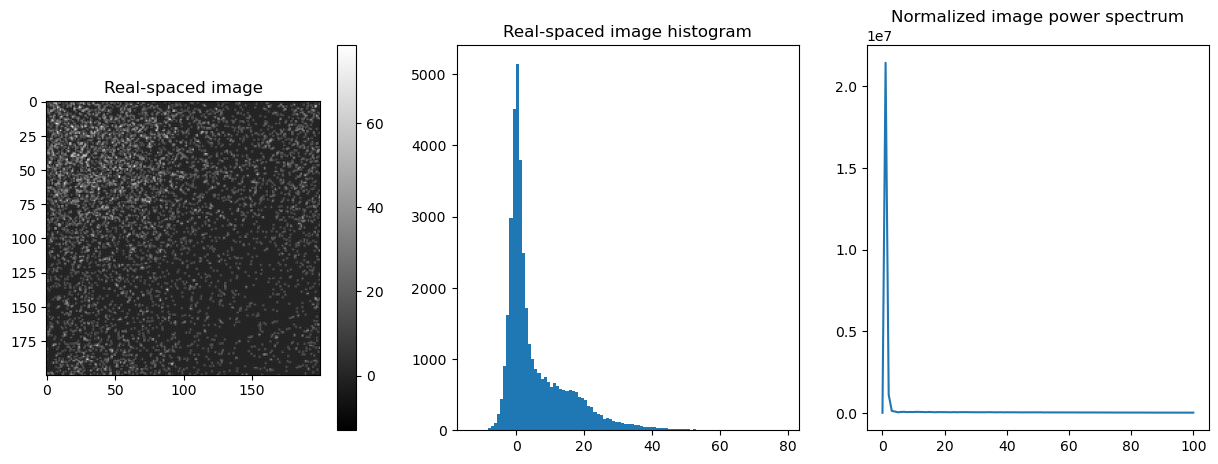

In [7]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
im = axes[0].imshow(image, cmap="gray")
axes[0].set_title("Real-spaced image")
fig.colorbar(im)
_ = axes[1].hist(image.flatten(), bins=100)
axes[1].set_title("Real-spaced image histogram")
_ = axes[2].plot(
    spectrum,
)
# axes[2].set_yscale('log')
axes[2].set_title("Normalized image power spectrum")

# Parkhurst solvation models

The solvaiton model in the original publication uses multislice. The solvent is added in outside the specimen slice by slice, via threshold based real spaced masking.

Here we simply use an additive model and add the solvent 'on top' of the specimen's potential, effectively adding solvent 'inside' the specimen. However since there is only one 'slice', thresholding would unphysically remove solvent from above/below the specimen, which seems more non-physical, especially for thick ice.



## UniformPhase

The first solvation model uses a deterministic power envelop from Parkhurst et al, and uniform phases.

In [8]:
import jax

import cryojax.simulator as cxs


solvent = cxs.UniformPhaseIce(power_envelope_function=cxs.Parkhurst2024_Gaussian())

# Number of simulations
num_simulations = 1000
image_shape = shape
voxel_size = 1

# Run simulations

randomseedkey = jax.random.PRNGKey(0)
phaseshifts = solvent.sample_ice_spectrum(
    key=randomseedkey, instrument_config=instrument_config
)
image = irfftn(phaseshifts, s=instrument_config.shape)
x2, y2 = compute_power_spectrum(image, shape=image_shape, voxel_size=voxel_size)
power_spectrum = y2


# ENVELOPE
def ParkhurstGaussian(q, a1, s1, a2, s2, m):
    return a1 * jnp.exp(-(q**2) / (2 * s1**2)) + a2 * jnp.exp(
        -((q - m) ** 2) / (2 * s2**2)
    )


a1 = 0.199
s1 = 0.731
a2 = 0.801
s2 = 0.081
m = 1 / 2.88
P_q = ParkhurstGaussian(x2, a1, s1, a2, s2, m)

# assert jnp.allclose(average_power_spectrum, P_q, atol=jnp.inf)

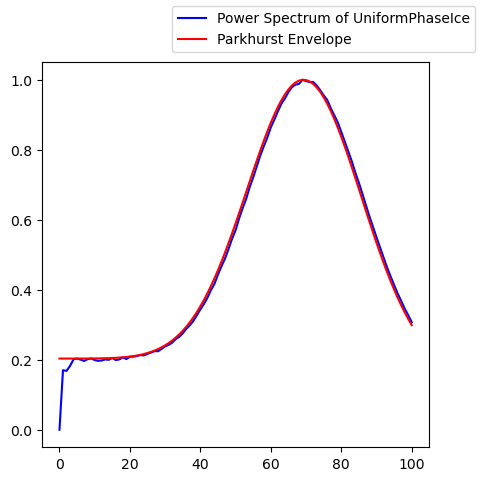

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(
    power_spectrum / power_spectrum.max(),
    color="blue",
    label="Power Spectrum of UniformPhaseIce",
)
ax.plot(P_q / P_q.max(), color="red", label="Parkhurst Envelope")
fig.legend()

## GaussianIce
This solvaiton model is a coloured noise model, which uses the double gaussian from Eq (2) in Parkhurst et al. as the power envelope function. 

Internally, a standar complex normal is sampled, and then mulitiplied by the radially Parkhurst's radially symmetric function. A standard complex normal $\mathcal{CN}[0,\text{variance} = \sigma^2]$ has random magnitude and phase [3, Appendix]. The phase is distributed uniformly, while the magnitude is distributed by the Raleigh distribution, with mean $\sigma \frac{\pi}{2}$ [4]. Internally things are scaled so that the mean of the magnitude is 1, thereby recovering the power evnelope in expectation.


- [3] https://en.wikipedia.org/wiki/Complex_normal_distribution
- [4] https://en.wikipedia.org/wiki/Rayleigh_distribution

In [11]:
import jax

import cryojax.simulator as cxs


solvent = cxs.GaussianIce(variance_function=cxs.Parkhurst2024_Gaussian())

# Number of simulations
num_simulations = 300
image_shape = shape
voxel_size = 1
power_spectra = jnp.zeros((num_simulations, image_shape[0] // 2 + 1))

# Run simulations
for i in range(num_simulations):
    randomseedkey = jax.random.split(jax.random.PRNGKey(0), num_simulations)[i]
    phaseshifts = solvent.sample_ice_spectrum(
        key=randomseedkey, instrument_config=instrument_config
    )
    image = irfftn(phaseshifts, s=instrument_config.shape)
    x2, y2 = compute_power_spectrum(image, shape=image_shape, voxel_size=voxel_size)
    power_spectra = power_spectra.at[i].set(y2)

# Compute the average power spectrum
average_power_spectrum = power_spectra.mean(axis=0)


# ENVELOPE
def ParkhurstGaussian(q, a1, s1, a2, s2, m):
    return a1 * jnp.exp(-(q**2) / (2 * s1**2)) + a2 * jnp.exp(
        -((q - m) ** 2) / (2 * s2**2)
    )


a1 = 0.199
s1 = 0.731
a2 = 0.801
s2 = 0.081
m = 1 / 2.88
P_q = ParkhurstGaussian(x2, a1, s1, a2, s2, m)

# assert jnp.allclose(average_power_spectrum, P_q, atol=jnp.inf)

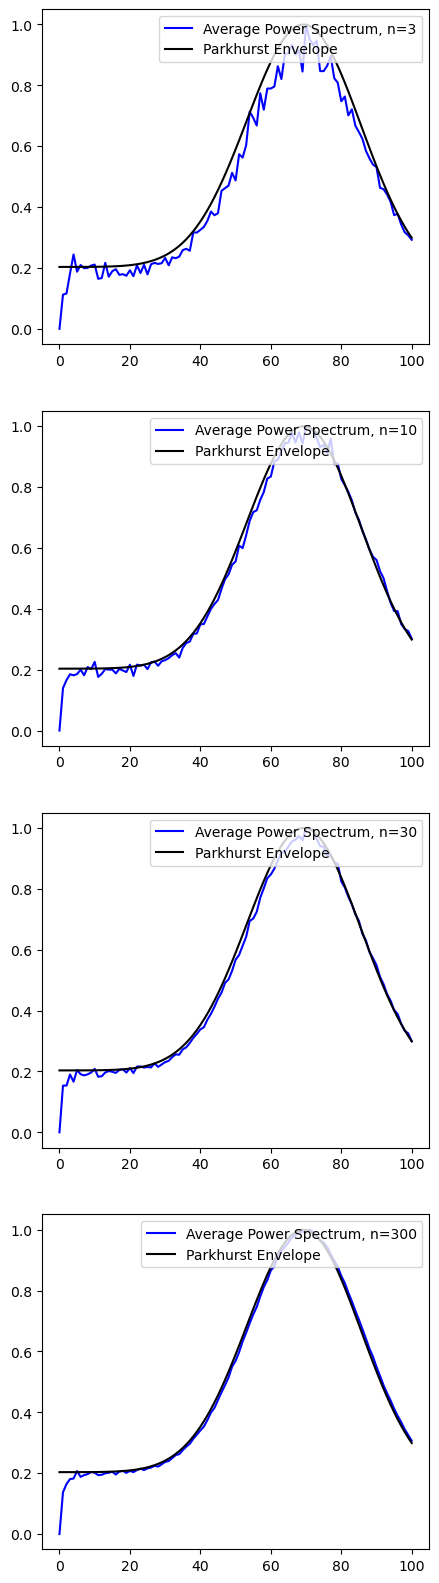

In [15]:
n_averages = [3, 10, 30, 300]

fig, axes = plt.subplots(len(n_averages), figsize=(5, 5 * len(n_averages)))
for idx, n_average in enumerate(n_averages):
    average_power_spectrum = power_spectra[:n_average].mean(0)
    axes[idx].plot(
        average_power_spectrum / average_power_spectrum.max(),
        label="Average Power Spectrum, n={}".format(n_averages[idx]),
        color="blue",
    )
    axes[idx].plot(P_q / P_q.max(), label="Parkhurst Envelope", color="black")
    axes[idx].legend(loc="upper right")  # Adjust the location as needed

plt.show()

## Appendix: complex normal distribution


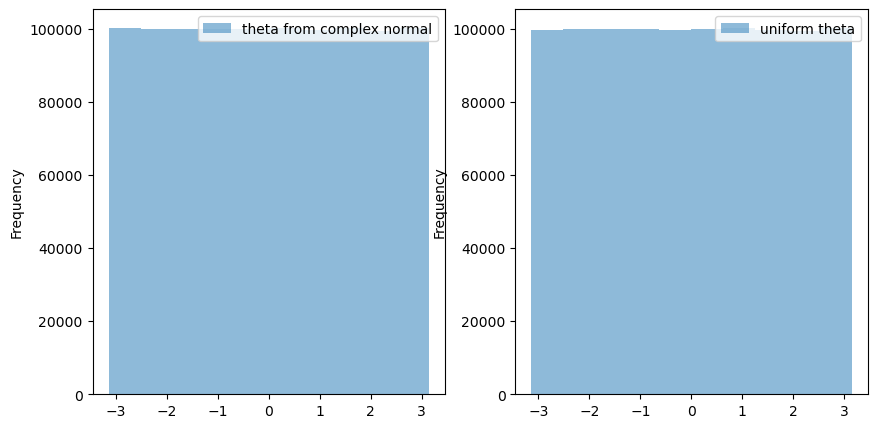

In [16]:
import jax.numpy as jnp
import jax.random as jr
import pandas as pd


n = 1000000
key = jr.key(0)
normal_rv = jr.normal(key, shape=(n,), dtype=complex)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

theta_rv = jnp.angle(normal_rv)
pd.Series(theta_rv).plot.hist(
    ax=axes[0], alpha=0.5, label="theta from complex normal", legend=True
)

uniform_rv = -jnp.pi + 2 * jnp.pi * jr.uniform(key, shape=(n,))
pd.Series(uniform_rv).plot.hist(ax=axes[1], alpha=0.5, label="uniform theta", legend=True)

assert np.isclose(theta_rv.mean(), uniform_rv.mean(), atol=1e-2)

The magnitude of the complex random variable is it's own random variable. 

<Axes: ylabel='Frequency'>

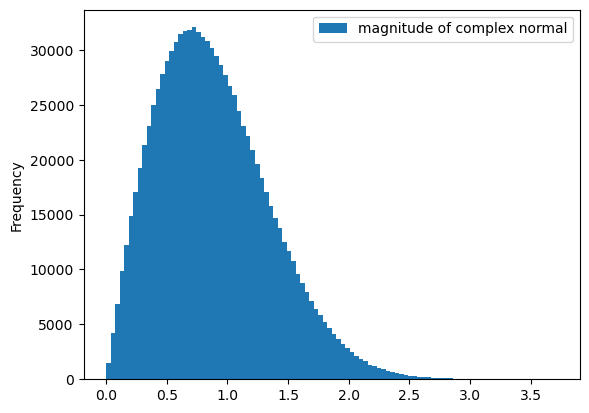

In [17]:
magnitude_rv = jnp.abs(normal_rv)
pd.Series(magnitude_rv).plot.hist(
    bins=100, label="magnitude of complex normal", legend=True
)

In [18]:
magnitude_rv.mean()

Array(0.88570696, dtype=float32)

In [19]:
analytic_mean = jnp.sqrt(jnp.pi / 2) / 2 ** (1 / 2)
analytic_mean

Array(0.88622695, dtype=float32, weak_type=True)

In [23]:
np.isclose(1, analytic_mean * 2 / jnp.sqrt(jnp.pi))

True

In [21]:
key1 = jr.key(1)
key2 = jr.key(2)
var_scale = 2 / jnp.pi
std_scale = jnp.sqrt(var_scale)
comlex_normals = std_scale * jr.normal(key2, shape=(n,)) + std_scale * 1j * jr.normal(
    key1, shape=(n,)
)

np.isclose(1, jnp.abs(comlex_normals).mean(), atol=1e-3)

True

In [22]:
var_scale = 4 / jnp.pi
std_scale = jnp.sqrt(var_scale)
comlex_normals = std_scale * jr.normal(key, shape=(n,), dtype=complex)


np.isclose(1, jnp.abs(comlex_normals).mean(), atol=1e-3)

True